In [1]:
!pip install yfinance


#Refrence https://www.youtube.com/watch?v=dKBKNOn3gCE    (decisionforest)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import  yfinance as yf
import warnings

from sklearn.preprocessing import MinMaxScaler
from keras.models  import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import  mean_squared_error
import math 
warnings.filterwarnings("ignore")
plt.style.use(style = 'seaborn')

%matplotlib inline

In [3]:
bitcoin_ticker = yf.Ticker("BTC-USD")
bitcoin_price = bitcoin_ticker.history(
    start='2021-04-10',
    end='2022-08-15',
    interval='60m'
).reset_index()


In [4]:
df = bitcoin_price

In [5]:
bitcoin_price

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-04-10 00:00:00+00:00,58253.777344,58400.804688,58038.707031,58212.460938,0,0,0
1,2021-04-10 01:00:00+00:00,58226.609375,58536.257812,58226.609375,58514.304688,67317760,0,0
2,2021-04-10 02:00:00+00:00,58532.867188,58703.160156,58460.089844,58703.160156,366772224,0,0
3,2021-04-10 03:00:00+00:00,58806.136719,59208.968750,58806.136719,59202.472656,1838604288,0,0
4,2021-04-10 04:00:00+00:00,59231.078125,60922.390625,59231.078125,60922.390625,5365641216,0,0
...,...,...,...,...,...,...,...,...
11586,2022-08-14 19:00:00+00:00,24294.511719,24322.357422,24275.544922,24304.109375,0,0,0
11587,2022-08-14 20:00:00+00:00,24303.839844,24338.433594,24276.894531,24324.968750,0,0,0
11588,2022-08-14 21:00:00+00:00,24325.814453,24413.955078,24302.974609,24341.371094,149147648,0,0
11589,2022-08-14 22:00:00+00:00,24340.982422,24352.015625,24231.068359,24337.230469,300048384,0,0


In [6]:
df.set_index('Datetime', drop = True, inplace = True)
df = df[['Close']]
df.describe()

,Close
count,11591.000000
mean,41378.997773
std,11671.502296
min,17744.896484
25%,33750.554688
50%,41441.398438
75%,48473.341797
max,68622.632812


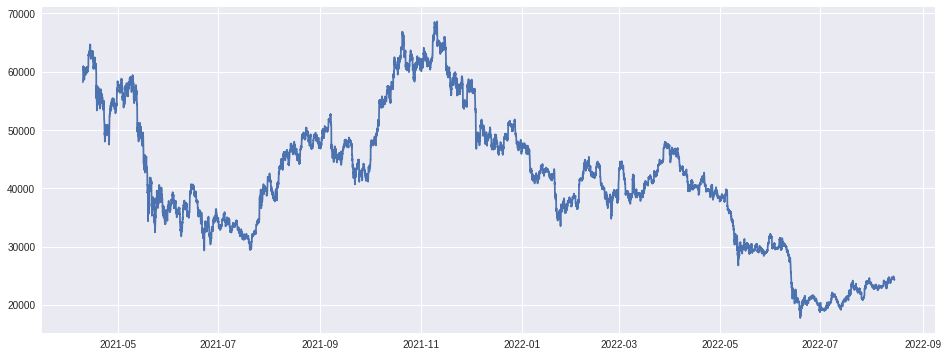

In [7]:
plt.figure(1,figsize = (16,6)) 
plt.plot(df.Close)

In [8]:
#calculating the returns

df['returns'] = df.Close.pct_change()


#calculating log returns
#log returns helps to convert values more nearer to normally ditributed curve

df['log_returns']= np.log(1+df['returns'])

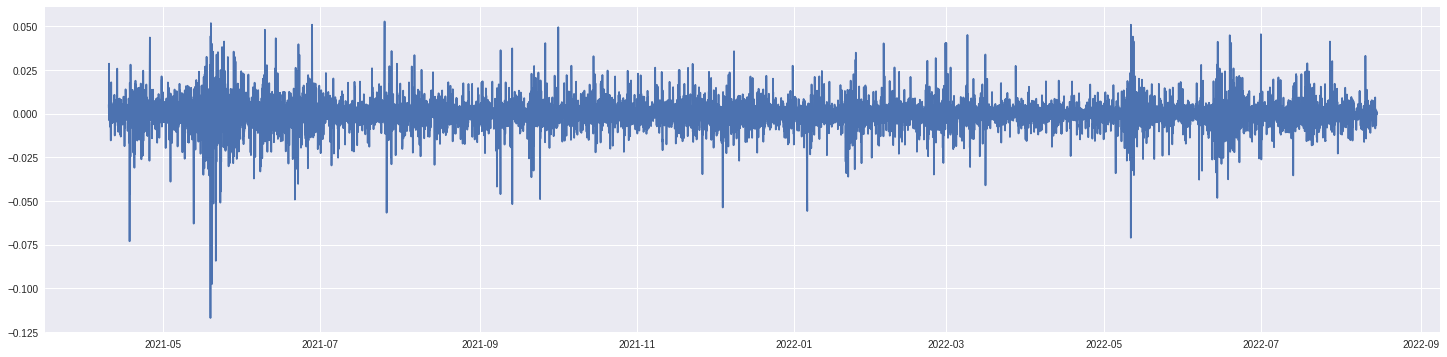

In [9]:
plt.figure(1,figsize = (25,6)) 
plt.plot(df.log_returns)

In [10]:
df.dropna(inplace = True)
X = df[['Close','log_returns']].values

#using minmax scaler from sklearn to scale the data without changinf distribution
#MinMax Scaler shrinks the data within the given range, usually of 0 to 1. It transforms data by scaling features to a given range. 
#It scales the values to a specific value range without changing the shape of the original distribution.
scaler = MinMaxScaler(feature_range = (0,1)).fit(X)
X_scaled = scaler.transform(X)

In [11]:
X_scaled[:5]

array([[0.80132119, 0.71940135],
       [0.80503314, 0.70791411],
       [0.81484711, 0.73883413],
       [0.84865203, 0.85767051],
       [0.84874462, 0.68938256]])

In [12]:
y = [x[0] for x in X_scaled]

In [13]:
split = int(len(X_scaled)* 0.8)
print(split)

9272


In [14]:
#splitting the training set and test set
X_train = X_scaled[:split]
X_test = X_scaled[split:len(X_scaled)]
y_train = y[:split]
y_test = y[split:len(y)]

In [15]:
assert len(X_train)== len(y_train)
assert len(X_test)== len(y_test)

In [16]:
#Lebelling 
#we are trying to predict the stock price of T+1 day related to time
#as we are going to use an LSTM architecture, we know that it has memomry  and that it is  maintained by setting the time step, basically how many steps  in the past we want the LSTM to use.

#the time step refer to how many  steps  in time we want  the backpropogation  algorithm  to use when  calculating  gradients  for weight updates during training.
#So we can use a method to create both the timestamp and the output variable, the T+1.





n = 3
Xtrain = []
ytrain = []
Xtest = []
ytest =[]

for i in range(n, len(X_train)):
  Xtrain.append(X_train[i- n:i,: X_train.shape[1]])
  ytrain.append(y_train[i]) #predict next record

for i in range(n,len(X_test)):
  Xtest.append(X_test[i-n:i,:X_test.shape[1]])
  ytest.append(y_test[i]) # predict the next record

In [17]:
Xtrain[0]

array([[0.80132119, 0.71940135],
       [0.80503314, 0.70791411],
       [0.81484711, 0.73883413]])

In [18]:
ytrain[0]

0.8486520285053774

In [19]:
val = np.array(ytrain[0])
val = np.c_[val, np.zeros(val.shape)]

In [20]:
scaler.inverse_transform(val)

array([[ 6.09223906e+04, -1.16917745e-01]])

In [21]:
#in an LSTM network the input for each LSTM layer needs to contain  the following information
#the number of obeservations
#the time steps
#the features
#therefore we need to add a temporaral dimension compared to a classical network

#(number of observations, number of steps, number of features per step)


Xtrain, ytrain = (np.array(Xtrain),np.array(ytrain))
Xtrain = np.reshape(Xtrain,(Xtrain.shape[0],Xtrain.shape[1],Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest),np.array(ytest))
Xtest = np.reshape(Xtest,(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2]))

In [22]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(9269, 3, 2)
(9269,)
(2315, 3, 2)
(2315,)


In [23]:
#LSTM Model


model = Sequential()
model.add(LSTM(4,input_shape = (Xtrain.shape[1],Xtrain.shape[2])))
model.add(Dense(1)) 
model.compile(loss= 'mean_squared_error',optimizer = 'adam')
model.fit( 
    Xtrain, ytrain, epochs = 100, validation_data = (Xtest,ytest),batch_size = 16, verbose = 1
)

Epoch 1/100
580/580 [==============================] - 5s 4ms/step - loss: 0.0718 - val_loss: 0.1135
Epoch 2/100
580/580 [==============================] - 2s 4ms/step - loss: 0.0108 - val_loss: 0.0178
Epoch 3/100
580/580 [==============================] - 3s 5ms/step - loss: 5.9964e-04 - val_loss: 0.0022
Epoch 4/100
580/580 [==============================] - 3s 5ms/step - loss: 9.0576e-05 - val_loss: 0.0022
Epoch 5/100
580/580 [==============================] - 3s 5ms/step - loss: 8.5653e-05 - val_loss: 0.0025
Epoch 6/100
580/580 [==============================] - 3s 5ms/step - loss: 8.2327e-05 - val_loss: 0.0027
Epoch 7/100
580/580 [==============================] - 3s 5ms/step - loss: 7.9378e-05 - val_loss: 0.0029
Epoch 8/100
580/580 [==============================] - 4s 6ms/step - loss: 7.7855e-05 - val_loss: 0.0031
Epoch 9/100
580/580 [==============================] - 4s 6ms/step - loss: 7.6207e-05 - val_loss: 0.0031
Epoch 10/100
580/580 [==============================] - 3s 6ms/

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 112       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [25]:
trainPredict  = model.predict(Xtrain)
testPredict  = model.predict(Xtest)

In [26]:
trainPredict

array([[0.8163476 ],
       [0.8487766 ],
       [0.84833574],
       ...,
       [0.2864148 ],
       [0.27770007],
       [0.27797455]], dtype=float32)

In [27]:
trainPredict = np.c_[trainPredict, np.zeros(trainPredict.shape)]
testPredict = np.c_[testPredict,np.zeros(testPredict.shape)]

In [28]:
#invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = [x[0] for x in trainPredict]

In [29]:
testPredict = scaler.inverse_transform(testPredict)
testPredict = [x[0] for x in testPredict]

In [30]:
print(trainPredict[:5])
print(testPredict[:5])

[59278.81437989789, 60928.7274672999, 60906.29873193148, 60763.70825910521, 60693.2378761291]
[32269.998423583453, 31892.23677727347, 31188.001476394766, 31372.741353342946, 31295.352208908876]


In [39]:
#calclate root mean square error 

trainScore = mean_squared_error([x[0][0] for x in Xtrain], trainPredict, squared = False)
print("Train Score: %.2f RMSE" % (trainScore))

testScore = mean_squared_error([x[0][0] for x in Xtest], testPredict, squared = False)
print("Test Score: %.2f RMSE" % (testScore))


Train Score: 46483.30 RMSE
Test Score: 25145.67 RMSE
